# CAO Project
---

This notebook contains:
 -  An overview of how to load CAO points information from the CAO website
 -  Appropriate plots and other visualisations of the data
 
By examining the data from 2021 and 2020 I hope to examine the impacts the COVID-19 pandemic has had on the Leaving Certificate. As the last two years have seen a change in how the Leaving Certificate is examined it will be interesting to see if this has had an affect on the course points. As the data from the CAO are not synonymous for comparing the 2021 and 2020 data to the data from years previous I will group the 2021 and 2020 data together for analysis and then group 2019 to 2017 (inclusive) together for analysis. 

<!-- For the years 2019 to 2017 I will not be examining EOS and will be focusing on Mid instead. The data is patchy for EOS and there is not enough data to be examined in a meaningful way. The same stands for R2 points for 2021 and 2020 as the data for R2 points is also extremely patchy this will not be examined. -->

## Background on the CAO
___

The Central Applications Office (CAO), founded in January 1976, is the organisation responsible for overseeing undergraduate applications to colleges and universities in the Republic of Ireland<sup>1</sup>. 
Undergraduates apply for entry into university through the CAO website and not through individual universities. The CAO is a points based system, with students getting the highest points securing offers from universities.

### Leaving Certificate Points
The points obtained from the leaving certificate exam determine what course the student is eligible for. Points for higher and ordinary level shown below<sup>2</sup>.

***Higher Level Points***

| Higher Level Grade | Points |
| -- | -- |
| H1 | 100|
| H2 | 88 |
| H3 | 77 |
| H4 | 66 |
| H5 | 56 |
| H6 | 46 |
| H7 | 37 |
| H8 | 0 |

***Ordinary Level Points***

| Ordinary Level Grade | Points |
| -- | -- |
| O1 | 56 |
| O2 | 46 |
| O3 | 37 |
| O4 | 28 |
| O5 | 20 |
| O6 | 12 |
| O7 | 0 |
| O8 | 0 |

A students points are calculated based on their six best subjects for a maximum score of 625, if the student takes and passes higher level maths<sup>2</sup>.

In [1]:
!pwd

/Users/saidhbhfoley/Desktop/repo/CAO-points


In [2]:
!ls

CAO Points Analysis.ipynb    data
PyPlot.ipynb                 requirements.txt
README.md                    ~$O2019_20211113_105625.docx
Untitled.ipynb


In [3]:
# !pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install --user

In [4]:
!pip install -U pandas-profiling

In [5]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## CAO Points Analysis


------

### Importing the Required Libraries

In [6]:
# Regualar expressions
import re

# Convient HTTP requests
import requests as rq

# Dates and times
import datetime as dt

import os

# Data frames
import pandas as pd

# For downloading
import urllib.request as urlrq

# Nice plots
import seaborn as sns

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

### Saving the datasets

It is best practice to save the dataset each time the data is ran, this ensures if the data on the websites is changed then the dataset will reflect these changes. In order for each save to not overwrite the previous version datetime is used.

In [7]:
# Get current date and time
now = dt.datetime.now()

# Format as a string
nowstr = now.strftime('%Y%m%d_%H%M%S')

<br>

## Obtaining the Data for the CAO 2021 Points
-----

The [2021 course points](http://www2.cao.ie/points/l8.php) for level 8 courses.

```Resquests``` allows you to send HTTP/1.1 requests extremely easily<sup>3</sup>. ```resp``` is the response object from which we get all the information we need<sup>4</sup>. The HTTP ```<Respoonse [200]>``` success status response code indicates that the request has succeeded<sup>5</sup>.

In [8]:
# Use resp.text to see the text
resp = rq.get('http://www2.cao.ie/points/l8.php')

# peak
resp

<Response [200]>

In [9]:
# Create a filepath for the original data
# Always sort year, month, date
pathhtml= 'data/CAO2021_' + nowstr + '.html'

#### Error on Server

Technically, the server says we should decode as per:
> Content-Type: text/html; charset=iso-8859-1

However one line uses \x96 which isn't defined in iso-8859-1
Therefore we use the similar decoding standard cp1252.

utf-8 usual decode but since Irish uses fadas you must decode using iso-8859-1 so it's not written in utf-8. Inspect the webpage and then it shows you the source code and network. In network headers you can see that the character set used is iso-8859-1.

In [10]:
# Server uses wrong encoding
original_encoding = resp.encoding

# Change to cp1252
resp.encoding = 'cp1252'

In [11]:
# Save original html file
with open(pathhtml, 'w') as f:
    f.write(resp.text)

#### Regular Expressions

Regular expressions can be used to clean the dataset. These work by searching and matching using a sequence if characters that the user specifies. Regular expressions can be used to remove rows/spaces/whitespaces that are not required. Below is the regular expression used to clean this dataset.
```(r'([A-Z]{2}[0-9]{3})  (.*)')```
The first part of this code ```(r'(``` denotes a raw string, followed by ```[A-Z]{2}``` which means any two capital letters between A and Z, followed by ```[0-9]{3}``` which looks for 3 numbers between 0 and 9 immediately after the two letters and finally ```(.*)')``` this looks for a wildcard (an unknown number of any character).

In [12]:
#Compile the regular expression for matching lines
re_course = re.compile(r'([A-Z]{2}[0-9]{3})  (.*)')

#### Creating the filepath


In [13]:
# The file path for the csv file.
path2021 = 'data/cao2021_csv_' + nowstr + '.csv'

In [14]:
# Keep track of how many courses we process.
no_lines=0

# Open the csv file for writing.
with open(path2021, 'w') as f:
    #Write a header row
    f.write(','.join(['code', 'title', 'pointsR1', 'pointsR2']) + '\n')
    for line in resp.iter_lines():
        dline = line.decode('cp1252')
        # Match only the lines we want - the ones representing courses.
        #if re.fullmatch('[A-Z]{2}[0-9]{3}  .*[0-9]{3}(\*)? *', line.decode('iso-8859-1')):
        if re_course.fullmatch(dline):
            no_lines = no_lines + 1
            #print(line)
            #csv_version = re_course.sub(r'\1,\2,\3\4', dline)
            #print(csv_version)
            #linesplit = re.split('  +', dline)
            # debug
            #print(len(linesplit), linesplit, dline)
            course_code = dline[:5]
            #print(course_code)
            course_title = dline[7:57].strip()
            # Round one points
            course_points = re.split(' +', dline[60:])
            if len(course_points) !=2:
            #print(f"'{course_title}'")
                course_points = course_points[:2]
            # join fields using a comma
            linesplit = [course_code, course_title, course_points[0], course_points[1]]
            f.write(','.join(linesplit) + '\n')
            #print(','.join(linesplit))
            
print(f"Total number of lines is {no_lines}.")

Total number of lines is 949.


<br>

**NB**: it was verified as of 13 Nov 2021 that there were 949 courses exactly in the CAO 2021 points list

In [15]:
header_list=['Code','Title', 'Points R1', 'Points R2']
df2021 = pd.read_csv(path2021, encoding='cp1252',names=header_list, skiprows=1)

#### Describing the 2021 Data

In [16]:
df2021

,Code,Title,Points R1,Points R2
0,AL801,Software Design for Virtual Reality and Gaming,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,321,NaN
4,AL810,Quantity Surveying,328,NaN
...,...,...,...,...
944,WD211,Creative Computing,270,NaN
945,WD212,Recreation and Sport Management,262,NaN
946,WD230,Mechanical and Manufacturing Engineering,230,230
947,WD231,Early Childhood Care and Education,266,NaN


In [17]:
 df2021.head()

,Code,Title,Points R1,Points R2
0,AL801,Software Design for Virtual Reality and Gaming,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,321,NaN
4,AL810,Quantity Surveying,328,NaN


<br>

## Obtaining the Data for the CAO 2020 Points
___

The [CAO points for 2020](https://www.cao.ie/index.php?page=points&p=2020) level 8 courses.

----

The CAO website does not offer each years data in the same format the data for 2020 courses is only available in an excel spreadsheet. However due to the inbuilt excel reader in pandas this makes it easier for us to create a CSV file.

As with the 2021 data, first the data is saved using the timestamp.

In [18]:
url2020 = 'http://www2.cao.ie/points/CAOPointsCharts2020.xlsx'

In [19]:
pathxlsx = 'data/CAO2020_' + nowstr + '.xlsx'

In [20]:
urlrq.urlretrieve(url2020, pathxlsx)

('data/CAO2020_20211222_204508.xlsx',
 <http.client.HTTPMessage at 0x7fdd5c3475e0>)

In [21]:
# Download and parse the excel
df2020 = pd.read_excel(url2020, skiprows = 10)

#### Describing the 2020 Data

In [22]:
df2020

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,Manufacturing and processing,Manufacturing Engineering,WD208,188,NaN,NaN,NaN,188,NaN,339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1460,Information and Communication Technologies (ICTs),Software Systems Development,WD210,279,NaN,NaN,NaN,279,NaN,337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1461,Information and Communication Technologies (ICTs),Creative Computing,WD211,271,NaN,NaN,NaN,271,NaN,318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1462,Personal services,Recreation and Sport Management,WD212,270,NaN,NaN,NaN,270,NaN,349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df2020.describe()

,LEVEL,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
count,1464.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,7.639344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.595939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CATEGORY (i.e.ISCED description)  1464 non-null   object 
 1   COURSE TITLE                      1464 non-null   object 
 2   COURSE CODE2                      1464 non-null   object 
 3   R1 POINTS                         1437 non-null   object 
 4   R1 Random *                       59 non-null     object 
 5   R2 POINTS                         333 non-null    object 
 6   R2 Random*                        29 non-null     object 
 7   EOS                               1448 non-null   object 
 8   EOS Random *                      69 non-null     object 
 9   EOS Mid-point                     1437 non-null   object 
 10  LEVEL                             1464 non-null   int64  
 11  HEI                               1464 non-null   object 
 12  Test/I

#### Spot Checking the 2020 Data

In [25]:
# Spot check random row
df2020.iloc[753]

CATEGORY (i.e.ISCED description)          Engineering and engineering trades
COURSE TITLE                        Road Transport Technology and Management
COURSE CODE2                                                           LC286
R1 POINTS                                                                264
R1 Random *                                                              NaN
R2 POINTS                                                                NaN
R2 Random*                                                               NaN
EOS                                                                      264
EOS Random *                                                             NaN
EOS Mid-point                                                            360
LEVEL                                                                      7
HEI                                         Limerick Institute of Technology
Test/Interview #                                                         NaN

In [26]:
# Spot check last row
df2020.iloc[1463]
# can also use -1 to get the very last row, -2 second last row......

CATEGORY (i.e.ISCED description)          Engineering and engineering trades
COURSE TITLE                        Mechanical and Manufacturing Engineering
COURSE CODE2                                                           WD230
R1 POINTS                                                                253
R1 Random *                                                              NaN
R2 POINTS                                                                NaN
R2 Random*                                                               NaN
EOS                                                                      253
EOS Random *                                                             NaN
EOS Mid-point                                                            369
LEVEL                                                                      8
HEI                                        Waterford Institute of Technology
Test/Interview #                                                         NaN

In [27]:
path2020 = 'data/CAO2020_' + nowstr + '.csv'

In [28]:
df2020.to_csv(path2020)

In [29]:
df2020.columns = [c.replace(' ', '_') for c in df2020.columns]

<br>

## Obtaining the Data for the CAO 2019 Points
---

The [CAO points for 2019](https://www.cao.ie/index.php?page=points&p=2019) for level 8 courses.

----

Again the data offered from the CAO site changes for 2019, for this year it's given in a pdf. This means the data was cleaned by hand as it is the quickest way to clean data gleaned from a pdf. Below are the steps I used to clean the data. Note as I use iOS there are some differences in how the data was converted to a csv file.

### Steps to reproduce

1. Download original pdf file
2. Open original pdf file with preview
3. Copy all to Microsoft Word
4. Save Microsoft Word's converted pdf in docx format
5. Re-save Word document for editing
6. Delete headers and Footers
7. Delete preamble at the start
8. Opened with vs code
9. Removed blank lines and college provider
10. Used find and replace to remove tabs and replace with comma
11. Used find and replace to remove all ` with '

In [30]:
df2019 = pd.read_csv('data/CAO2019_20211113_105625_edited.csv', sep='\t')

#### Describing the 2019 Data

In [31]:
df2019

,Code,Title,EOS,Mid
0,AL801,Software Design with Virtual Reality and Gaming,304,328
1,AL802,Software Design with Cloud Computing,301,306
2,AL803,Software Design with Mobile Apps and Connected...,309,337
3,AL805,Network Management and Cloud Infrastructure,329,442
4,AL810,Quantity Surveying,307,349
...,...,...,...,...
925,WD200,Arts (options),221,296
926,WD210,Software Systems Development,271,329
927,WD211,Creative Computing,275,322
928,WD212,Recreation and Sport Management,274,311


**Note**: As 2019 data does not offer Round 1 and Round 2 data this will make analysing the three dataframes less accurate.

<br>

## Obtaining the Data for the CAO 2018 Points
---

The [CAO points for 2018](https://www.cao.ie/index.php?page=points&p=2018) for level 8 courses.

----

Similar to 2019 the 2018 data were given in pdf format meaning the data was cleaned by hand as it is the quickest way to clean data gleaned from a pdf. Below are the steps I used to clean the data. Note as I use iOS there are some differences in how the data was converted to a csv file.

### Steps to reproduce

1. Download original pdf file
2. Open original pdf file with preview
3. Copy all to Microsoft Word
4. Save Microsoft Word's converted pdf in docx format
5. Re-save Word document for editing
6. Delete headers and Footers
7. Delete preamble at the start
8. Opened with vs code
9. Removed blank lines and college provider
10. Used find and replace to remove tabs and replace with comma
11. Used find and replace to remove all ` with '

In [32]:
df2018 = pd.read_csv('data/CAO2018_20211211_133605.csv', sep='\t')

#### Describing the 2018 Data

In [33]:
df2018

,Code,Title,EOS,Mid
0,AL801,Software Design (Game Development or Cloud Com...,295,326.0
1,AL810,Quantity Surveying,300,340.0
2,AL820,Mechanical and Polymer Engineering,299,371.0
3,AL830,General Nursing,418,440.0
4,AL832,Psychiatric Nursing,377,388.0
...,...,...,...,...
898,WD197,The Internet of Things,260,329.0
899,WD200,Arts,220,299.0
900,WD210,Software Systems Development,289,327.0
901,WD211,Creative Computing,265,326.0


<br>

## Obtaining the Data for the CAO 2017 Points
---

The [CAO points for 2017](https://www.cao.ie/index.php?page=points&p=2017) for level 8 courses.

----

Similar to 2019 and 2018 data, the 2017 data were given in pdf format meaning the data was cleaned by hand as it is the quickest way to clean data gleaned from a pdf. Below are the steps I used to clean the data. Note as I use iOS there are some differences in how the data was converted to a csv file.

### Steps to reproduce

1. Download original pdf file
2. Open original pdf file with preview
3. Copy all to Microsoft Word
4. Save Microsoft Word's converted pdf in docx format
5. Re-save Word document for editing
6. Delete headers and Footers
7. Delete preamble at the start
8. Opened with vs code
9. Removed blank lines and college provider
10. Used find and replace to remove tabs and replace with comma
11. Used find and replace to remove all ` with '
12. Updated header to Code and Title

In [34]:
df2017 = pd.read_csv('data/CAO2017_20211211_14-50-35_edited.csv', sep='\t')

#### Describing the 2017 Data

In [35]:
df2017

,Code,Title,Final,Mid
0,AL801,Software Design (Game Development or Cloud Com...,290,329.0
1,AL810,Quantity Surveying,311,357.0
2,AL820,Mechanical and Polymer Engineering,300,336.0
3,AL830,General Nursing,398*,418.0
4,AL832,Psychiatric Nursing,378,389.0
...,...,...,...,...
860,WD193,Marketing and Digital Media,297,337.0
861,WD194,Culinary Arts,279,356.0
862,WD195,Architectural & Building Information Modelling...,273,320.0
863,WD197,The Internet of Things,262,328.0


## Cleaning the Dataset
---

Upon examining the dataset there were still characters that needed to be removed in order to perform analysis on the data set therefore I removed the #, * and the +matrix from each year

In [36]:
df2021=df2021.replace('\#','',regex=True)
df2021=df2021.replace('\*','',regex=True)
df2021=df2021.replace('\+matric','',regex=True)

In [37]:
df2020=df2020.replace('\#','',regex=True)
df2020=df2020.replace('\*','',regex=True)
df2020=df2020.replace('\+matric','',regex=True)

In [38]:
df2019=df2019.replace('\#','',regex=True)
df2019=df2019.replace('\*','',regex=True)
df2019=df2019.replace('\+matric','',regex=True)

In [39]:
df2018=df2018.replace('\#','',regex=True)
df2018=df2018.replace('\*','',regex=True)
df2018=df2018.replace('\+matric','',regex=True)

In [40]:
df2017=df2017.replace('\#','',regex=True)
df2017=df2017.replace('\*','',regex=True)
df2017=df2017.replace('\+matric','',regex=True)

<br>

## Concat and Join
***

Joining the codes and titles for each year. This is done by first creating a dataframe containing the code and title for each year, then joining all the years codes and titles together, removing any duplicates. 

### Joining Code and Title for 2021

Joining code and title by creating new dataframe courses2021

In [41]:
courses2021 = df2021[['Code', 'Title']]

In [42]:
courses2021

,Code,Title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying
...,...,...
944,WD211,Creative Computing
945,WD212,Recreation and Sport Management
946,WD230,Mechanical and Manufacturing Engineering
947,WD231,Early Childhood Care and Education


### Joining Code and Title for 2020

Joining code and title by creating new dataframe courses2020

In [43]:
courses2020 = df2020[['COURSE_CODE2', 'COURSE_TITLE']]
courses2020.columns = ['Code', 'Title']

In [44]:
courses2020

,Code,Title
0,AC120,International Business
1,AC137,Liberal Arts
2,AD101,"First Year Art & Design (Common Entry,portfolio)"
3,AD102,Graphic Design and Moving Image Design (portfo...
4,AD103,Textile & Surface Design and Jewellery & Objec...
...,...,...
1459,WD208,Manufacturing Engineering
1460,WD210,Software Systems Development
1461,WD211,Creative Computing
1462,WD212,Recreation and Sport Management


### Joining Code and Title for 2019

Joining code and title by creating new dataframe courses2019

In [45]:
courses2019 = df2019[['Code', 'Title']]
courses2019

,Code,Title
0,AL801,Software Design with Virtual Reality and Gaming
1,AL802,Software Design with Cloud Computing
2,AL803,Software Design with Mobile Apps and Connected...
3,AL805,Network Management and Cloud Infrastructure
4,AL810,Quantity Surveying
...,...,...
925,WD200,Arts (options)
926,WD210,Software Systems Development
927,WD211,Creative Computing
928,WD212,Recreation and Sport Management


### Joining Code and Title for 2018

Joining code and title by creating new dataframe courses2018

In [46]:
courses2018 = df2018[['Code', 'Title']]
courses2018

,Code,Title
0,AL801,Software Design (Game Development or Cloud Com...
1,AL810,Quantity Surveying
2,AL820,Mechanical and Polymer Engineering
3,AL830,General Nursing
4,AL832,Psychiatric Nursing
...,...,...
898,WD197,The Internet of Things
899,WD200,Arts
900,WD210,Software Systems Development
901,WD211,Creative Computing


### Joining Code and Title for 2017

Joining code and title by creating new dataframe courses2017

In [47]:
courses2017 = df2017[['Code', 'Title']]
courses2017

,Code,Title
0,AL801,Software Design (Game Development or Cloud Com...
1,AL810,Quantity Surveying
2,AL820,Mechanical and Polymer Engineering
3,AL830,General Nursing
4,AL832,Psychiatric Nursing
...,...,...
860,WD193,Marketing and Digital Media
861,WD194,Culinary Arts
862,WD195,Architectural & Building Information Modelling...
863,WD197,The Internet of Things


### Joining the dataframes 2021 - 2017

In [48]:
allcourses = pd.concat([courses2021, courses2020, courses2019, courses2018, courses2017], ignore_index=True)

allcourses

,Code,Title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying
...,...,...
5106,WD193,Marketing and Digital Media
5107,WD194,Culinary Arts
5108,WD195,Architectural & Building Information Modelling...
5109,WD197,The Internet of Things


In [49]:
# allcourses.reset_index()

### Sorting the Dataframe by 'Code'

In [50]:
allcourses.sort_values('Code')

,Code,Title
175,AC120,International Business
949,AC120,International Business
2581,AC120,International Business
4399,AC120,International Business
3498,AC120,International Business
...,...,...
3342,WD230,Mechanical and Manufacturing Engineering
2412,WD230,Mechanical and Manufacturing Engineering
946,WD230,Mechanical and Manufacturing Engineering
947,WD231,Early Childhood Care and Education


In [51]:
#allcourses.loc[175]['Title']

In [52]:
#allcourses.loc[949]['Title']

In [53]:
# Finds all extra copies of duplicated rows
#allcourses[allcourses.duplicated()]

In [54]:
# Dataframe with duplicates removed
#allcourses.drop_duplicates()

### Removing Duplicated from allcourses

In [55]:
# Finds all extra copies of duplicated rows
allcourses[allcourses.duplicated(subset=['Code'])]

,Code,Title
949,AC120,International Business
950,AC137,Liberal Arts
951,AD101,"First Year Art & Design (Common Entry,portfolio)"
952,AD102,Graphic Design and Moving Image Design (portfo...
953,AD103,Textile & Surface Design and Jewellery & Objec...
...,...,...
5106,WD193,Marketing and Digital Media
5107,WD194,Culinary Arts
5108,WD195,Architectural & Building Information Modelling...
5109,WD197,The Internet of Things


In [56]:
# Dataframe with duplicates removed - based only on code
allcourses.drop_duplicates(subset=['Code'], inplace=True, ignore_index=True)

In [57]:
allcourses.set_index('Code', inplace=True)

In [58]:
allcourses

,Title
Code,
AL801,Software Design for Virtual Reality and Gaming
AL802,Software Design in Artificial Intelligence for...
AL803,Software Design for Mobile Apps and Connected ...
AL805,Computer Engineering for Network Infrastructure
AL810,Quantity Surveying
...,...
WD124,Health Promotion
WD125,Exercise and Health Studies
WD160,Finance and Investment


<br>

### Joining Courses to the Points
-----
After each years course code and title have been integrated the points for each of the years are then joined to create the dataset I will analyse.

#### Adding Points to 2021 Data

In [59]:
# Set index to code column
df2021.set_index('Code', inplace=True)
df2021.columns = ['Title','points_R1_2021','points_R2_2021']
df2021

,Title,points_R1_2021,points_R2_2021
Code,,,
AL801,Software Design for Virtual Reality and Gaming,300,NaN
AL802,Software Design in Artificial Intelligence for...,313,NaN
AL803,Software Design for Mobile Apps and Connected ...,350,NaN
AL805,Computer Engineering for Network Infrastructure,321,NaN
AL810,Quantity Surveying,328,NaN
...,...,...,...
WD211,Creative Computing,270,NaN
WD212,Recreation and Sport Management,262,NaN
WD230,Mechanical and Manufacturing Engineering,230,230


In [60]:
allcourses = allcourses.join(df2021[['points_R1_2021','points_R2_2021']])
allcourses

,Title,points_R1_2021,points_R2_2021
Code,,,
AL801,Software Design for Virtual Reality and Gaming,300,NaN
AL802,Software Design in Artificial Intelligence for...,313,NaN
AL803,Software Design for Mobile Apps and Connected ...,350,NaN
AL805,Computer Engineering for Network Infrastructure,321,NaN
AL810,Quantity Surveying,328,NaN
...,...,...,...
WD124,Health Promotion,NaN,NaN
WD125,Exercise and Health Studies,NaN,NaN
WD160,Finance and Investment,NaN,NaN


#### Adding Points to 2020 Data

In [61]:
df2020.set_index('COURSE_CODE2', inplace=True)

In [62]:
df2020_r1 = df2020[['R1_POINTS','R2_POINTS']]
df2020_r1.columns = ['points_R1_2020', 'points_R2_2020']
df2020_r1

,points_R1_2020,points_R2_2020
COURSE_CODE2,,
AC120,209,NaN
AC137,252,NaN
AD101,,NaN
AD102,,NaN
AD103,,NaN
...,...,...
WD208,188,NaN
WD210,279,NaN
WD211,271,NaN


In [63]:
#df2020_r1.set_index('Code', inplace=True)
#df2020_r1

In [64]:
allcourses = allcourses.join(df2020_r1)
allcourses

,Title,points_R1_2021,points_R2_2021,points_R1_2020,points_R2_2020
Code,,,,,
AL801,Software Design for Virtual Reality and Gaming,300,NaN,303,NaN
AL802,Software Design in Artificial Intelligence for...,313,NaN,332,NaN
AL803,Software Design for Mobile Apps and Connected ...,350,NaN,337,NaN
AL805,Computer Engineering for Network Infrastructure,321,NaN,333,NaN
AL810,Quantity Surveying,328,NaN,319,NaN
...,...,...,...,...,...
WD124,Health Promotion,NaN,NaN,NaN,NaN
WD125,Exercise and Health Studies,NaN,NaN,NaN,NaN
WD160,Finance and Investment,NaN,NaN,NaN,NaN


#### Adding Points to 2019 Data

In [65]:
df2019.set_index('Code', inplace=True)
df2019.columns = ['Title','EOS_2019','Mid_2019']
df2019

,Title,EOS_2019,Mid_2019
Code,,,
AL801,Software Design with Virtual Reality and Gaming,304,328
AL802,Software Design with Cloud Computing,301,306
AL803,Software Design with Mobile Apps and Connected...,309,337
AL805,Network Management and Cloud Infrastructure,329,442
AL810,Quantity Surveying,307,349
...,...,...,...
WD200,Arts (options),221,296
WD210,Software Systems Development,271,329
WD211,Creative Computing,275,322


In [66]:
allcourses=allcourses.join(df2019[['EOS_2019','Mid_2019']])
allcourses

,Title,points_R1_2021,points_R2_2021,points_R1_2020,points_R2_2020,EOS_2019,Mid_2019
Code,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,300,NaN,303,NaN,304,328
AL802,Software Design in Artificial Intelligence for...,313,NaN,332,NaN,301,306
AL803,Software Design for Mobile Apps and Connected ...,350,NaN,337,NaN,309,337
AL805,Computer Engineering for Network Infrastructure,321,NaN,333,NaN,329,442
AL810,Quantity Surveying,328,NaN,319,NaN,307,349
...,...,...,...,...,...,...,...
WD124,Health Promotion,NaN,NaN,NaN,NaN,NaN,NaN
WD125,Exercise and Health Studies,NaN,NaN,NaN,NaN,NaN,NaN
WD160,Finance and Investment,NaN,NaN,NaN,NaN,NaN,NaN


#### Adding Points to 2018 Data

In [67]:
df2018.set_index('Code', inplace=True)
df2018.columns = ['Title','EOS_2018','Mid_2018']
df2018

,Title,EOS_2018,Mid_2018
Code,,,
AL801,Software Design (Game Development or Cloud Com...,295,326.0
AL810,Quantity Surveying,300,340.0
AL820,Mechanical and Polymer Engineering,299,371.0
AL830,General Nursing,418,440.0
AL832,Psychiatric Nursing,377,388.0
...,...,...,...
WD197,The Internet of Things,260,329.0
WD200,Arts,220,299.0
WD210,Software Systems Development,289,327.0


In [68]:
allcourses=allcourses.join(df2018[['EOS_2018','Mid_2018']])
allcourses

,Title,points_R1_2021,points_R2_2021,points_R1_2020,points_R2_2020,EOS_2019,Mid_2019,EOS_2018,Mid_2018
Code,,,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,300,NaN,303,NaN,304,328,NaN,NaN
AL802,Software Design in Artificial Intelligence for...,313,NaN,332,NaN,301,306,NaN,NaN
AL803,Software Design for Mobile Apps and Connected ...,350,NaN,337,NaN,309,337,NaN,NaN
AL805,Computer Engineering for Network Infrastructure,321,NaN,333,NaN,329,442,NaN,NaN
AL810,Quantity Surveying,328,NaN,319,NaN,307,349,NaN,NaN
...,...,...,...,...,...,...,...,...,...
WD124,Health Promotion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WD125,Exercise and Health Studies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WD160,Finance and Investment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Adding Points to 2017 Data

In [69]:
df2017.set_index('Code', inplace=True)
df2017.columns = ['Title','EOS_2017','Mid_2017']
df2017

,Title,EOS_2017,Mid_2017
Code,,,
AL801,Software Design (Game Development or Cloud Com...,290,329.0
AL810,Quantity Surveying,311,357.0
AL820,Mechanical and Polymer Engineering,300,336.0
AL830,General Nursing,398,418.0
AL832,Psychiatric Nursing,378,389.0
...,...,...,...
WD193,Marketing and Digital Media,297,337.0
WD194,Culinary Arts,279,356.0
WD195,Architectural & Building Information Modelling...,273,320.0


In [70]:
allcourses=allcourses.join(df2017[['EOS_2017','Mid_2017']])
allcourses

,Title,points_R1_2021,points_R2_2021,points_R1_2020,points_R2_2020,EOS_2019,Mid_2019,EOS_2018,Mid_2018,EOS_2017,Mid_2017
Code,,,,,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,300,NaN,303,NaN,304,328,NaN,NaN,NaN,NaN
AL802,Software Design in Artificial Intelligence for...,313,NaN,332,NaN,301,306,NaN,NaN,NaN,NaN
AL803,Software Design for Mobile Apps and Connected ...,350,NaN,337,NaN,309,337,NaN,NaN,NaN,NaN
AL805,Computer Engineering for Network Infrastructure,321,NaN,333,NaN,329,442,NaN,NaN,NaN,NaN
AL810,Quantity Surveying,328,NaN,319,NaN,307,349,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
WD124,Health Promotion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296,347.0
WD125,Exercise and Health Studies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273,316.0
WD160,Finance and Investment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310,390.0


## Examining the Dataset
***

Before analysing the data it is important to first examine the data. First I will use value_counts() to display the unique counts, i.e. how many courses required the same amount of points to gain entry into that course. Then I will use df.describe() to summarise the general stats of each year. Finally I will use df.info() to get information on the dataframe such as the dtype, and information on the NaN values.

### Examining the 2021 Dataset

Here I will look at how many unique points there are in the dataset. I will then use df.describe() to get a general description of the dataset, I will also use df.info() for further examination of the dataset.

In [71]:
allcourses['points_R1_2021'].value_counts()

300    19
270    15
309    13
498    11
308    11
       ..
588     1
211     1
219     1
386     1
237     1
Name: points_R1_2021, Length: 319, dtype: int64

In [72]:
df2021.describe()

,Title,points_R1_2021,points_R2_2021
count,949,928,258
unique,709,319,160
top,Business,300,613
freq,12,19,6


In [73]:
df2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 949 entries, AL801 to WD232
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Title           949 non-null    object
 1   points_R1_2021  928 non-null    object
 2   points_R2_2021  258 non-null    object
dtypes: object(3)
memory usage: 61.9+ KB


In [74]:
print(df2021.loc[df2021['points_R1_2021'] == 'AQA'])

                                                   Title points_R1_2021  \
Code                                                                      
MH801  Early Childhood - Teaching and Learning (part-...            AQA   

      points_R2_2021  
Code                  
MH801            AQA  


In 2021 one of the entries had "AQA" so we choose to remove this particular entry from further analysis.

In [75]:
df2021 = df2021.loc[df2021['points_R1_2021'] != "AQA"]

In [76]:
df2021

,Title,points_R1_2021,points_R2_2021
Code,,,
AL801,Software Design for Virtual Reality and Gaming,300,NaN
AL802,Software Design in Artificial Intelligence for...,313,NaN
AL803,Software Design for Mobile Apps and Connected ...,350,NaN
AL805,Computer Engineering for Network Infrastructure,321,NaN
AL810,Quantity Surveying,328,NaN
...,...,...,...
WD211,Creative Computing,270,NaN
WD212,Recreation and Sport Management,262,NaN
WD230,Mechanical and Manufacturing Engineering,230,230


In [77]:
df2021.points_R1_2021 = pd.to_numeric(df2021.points_R1_2021)
#print(df2021)

/Users/saidhbhfoley/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [78]:
df2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 948 entries, AL801 to WD232
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           948 non-null    object 
 1   points_R1_2021  923 non-null    float64
 2   points_R2_2021  257 non-null    object 
dtypes: float64(1), object(2)
memory usage: 29.6+ KB


In [79]:
df2021.isna().sum().sort_values(ascending = False) / len(df2021)

points_R2_2021    0.728903
points_R1_2021    0.026371
Title             0.000000
dtype: float64

72% values are NaN for R2 Points in 2021, 2% values are NaN for 2021 for R1 Points, hence we are focusing on R1 for 2021.

### Examining the 2020 Dataset

Here I will use df.describe() to get a general description of the dataset, however as this command works on floats it will not describe the objects in the dataset therefore I will also use df.info() for further examination of the dataset. Finally I will look at how many unique points there are in the dataset.

In [80]:
df2020.describe()

,LEVEL,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
count,1464.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,7.639344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.595939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
df2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1464 entries, AC120 to WD230
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CATEGORY_(i.e.ISCED_description)  1464 non-null   object 
 1   COURSE_TITLE                      1464 non-null   object 
 2   R1_POINTS                         1437 non-null   object 
 3   R1_Random_*                       59 non-null     object 
 4   R2_POINTS                         333 non-null    object 
 5   R2_Random*                        29 non-null     object 
 6   EOS                               1448 non-null   object 
 7   EOS_Random_*                      69 non-null     object 
 8   EOS_Mid-point                     1437 non-null   object 
 9   LEVEL                             1464 non-null   int64  
 10  HEI                               1464 non-null   object 
 11  Test/Interview_#                  127 non-null    object 
 12  avp   

In [82]:
df2020.isna().sum().sort_values(ascending = False) / len(df2020)

Column8                             1.000000
Column7                             1.000000
Column6                             1.000000
Column5                             1.000000
Column4                             1.000000
Column3                             1.000000
Column2                             1.000000
Column1                             1.000000
v                                   0.991803
R2_Random*                          0.980191
R1_Random_*                         0.959699
EOS_Random_*                        0.952869
Test/Interview_#                    0.913251
avp                                 0.855191
R2_POINTS                           0.772541
EOS_Mid-point                       0.018443
R1_POINTS                           0.018443
EOS                                 0.010929
COURSE_TITLE                        0.000000
HEI                                 0.000000
LEVEL                               0.000000
CATEGORY_(i.e.ISCED_description)    0.000000
dtype: flo

77% of values for R2 in 2020 are NaN, while only 1% of 2020 R1 points are NaN, hence focusing on R1 for 2020.

In [83]:
allcourses['points_R1_2020'].value_counts()

AQA    26
300    26
280    18
270    18
       17
       ..
502     1
728     1
312     1
375     1
222     1
Name: points_R1_2020, Length: 388, dtype: int64

We are only choosing R1 for 2020 and 2021 the reason being there are less non-null values compared to the total number of values especially for 2020 <1/3 are values.

### Examining the 2019 Dataset

Here I will look at how many unique points there are in the dataset. I will then use df.describe() to get a general description of the dataset, I will also use df.info() for further examination of the dataset.

In [84]:
allcourses['Mid_2019'].value_counts()

543    14
388    13
338    13
466    12
487    11
       ..
412     1
452     1
579     1
522     1
294     1
Name: Mid_2019, Length: 278, dtype: int64

In [85]:
df2019.describe()

,Title,EOS_2019,Mid_2019
count,930,926,915
unique,719,307,278
top,Accounting and Finance,300,543
freq,11,32,14


In [86]:
df2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 930 entries, AL801 to WD230
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     930 non-null    object
 1   EOS_2019  926 non-null    object
 2   Mid_2019  915 non-null    object
dtypes: object(3)
memory usage: 61.4+ KB


### Examining the 2018 Dataset

Here I will look at how many unique points there are in the dataset. I will then use df.describe() to get a general description of the dataset, I will also use df.info() for further examination of the dataset.

In [87]:
allcourses['Mid_2018'].value_counts()

347.0    14
357.0    13
388.0    13
473.0    13
462.0    11
         ..
836.0     1
545.0     1
463.0     1
643.0     1
379.0     1
Name: Mid_2018, Length: 255, dtype: int64

In [88]:
df2018.describe()

,Mid_2018
count,875.000000
mean,422.273143
std,127.488725
min,56.000000
25%,338.000000
50%,392.000000
75%,476.000000
max,1045.000000


In [89]:
df2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 903 entries, AL801  to WD212 
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Title     903 non-null    object 
 1   EOS_2018  891 non-null    object 
 2   Mid_2018  875 non-null    float64
dtypes: float64(1), object(2)
memory usage: 60.5+ KB


### Examining the 2017 Dataset

Here I will look at how many unique points there are in the dataset. I will then use df.describe() to get a general description of the dataset, I will also use df.info() for further examination of the dataset.

In [90]:
allcourses['Mid_2017'].value_counts()

347.0    14
357.0    13
476.0    12
337.0    11
430.0    11
         ..
852.0     1
369.0     1
862.0     1
503.0     1
400.0     1
Name: Mid_2017, Length: 256, dtype: int64

In [91]:
df2017.describe()

,Mid_2017
count,847.000000
mean,425.227863
std,128.648223
min,57.000000
25%,339.000000
50%,399.000000
75%,478.000000
max,1068.000000


In [92]:
df2017.info()

<class 'pandas.core.frame.DataFrame'>
Index: 865 entries, AL801  to WD200 
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Title     865 non-null    object 
 1   EOS_2017  855 non-null    object 
 2   Mid_2017  847 non-null    float64
dtypes: float64(1), object(2)
memory usage: 59.3+ KB


## Cleaning the Dataset
---

Upon examining the dataset there were still characters that needed to be removed in order to perform analysis on the data set therefore I removed the #, * and the +matrix from each year

## Comparing 2021 and 2020 Dataset
***

Before comparing the data between the years 2021 and 2020, first I will examine the data to see how many courses are in both years so I can compare the course points for these years. I will use .unique() to compare the course titles between the two years data. By comparing the course titles I'll understand if some courses were dropped after 2020 or added in 2021.

### 2021 Courses
First I will look into the 2021 courses that were on offer and find how many unique titles there were.

In [93]:
df2021.Title.unique()

array(['Software Design for Virtual Reality and Gaming',
       'Software Design in Artificial Intelligence for Clo',
       'Software Design for Mobile Apps and Connected Devi',
       'Computer Engineering for Network Infrastructure',
       'Quantity Surveying', 'Civil Engineering',
       'Mechanical and Polymer Engineering', 'General Nursing',
       'Mental Health Nursing', 'Pharmacology',
       'Nutrition and Health Science',
       'Sports Science with Exercise Physiology', 'Biotechnology',
       'Microbiology', 'Pharmaceutical Sciences',
       'Athletic and Rehabilitation Therapy', 'Bioveterinary Science',
       'Physical Activity and Health Science',
       'Culinary Entrepreneurship', 'Business', 'Business and Law',
       'Accounting', 'Sport Management (with international placement)',
       'Hospitality Management (with international placeme',
       'Digital Marketing', 'International Business',
       'Social Care Practice', 'Animation and Illustration (portfolio)',

In [94]:
len(df2021.Title.unique())

708

In [95]:
df2021['points_R1_2021'].to_frame()

,points_R1_2021
Code,
AL801,300.0
AL802,313.0
AL803,350.0
AL805,321.0
AL810,328.0
...,...
WD211,270.0
WD212,262.0
WD230,230.0


In [96]:
df2021.head()

,Title,points_R1_2021,points_R2_2021
Code,,,
AL801,Software Design for Virtual Reality and Gaming,300.0,NaN
AL802,Software Design in Artificial Intelligence for...,313.0,NaN
AL803,Software Design for Mobile Apps and Connected ...,350.0,NaN
AL805,Computer Engineering for Network Infrastructure,321.0,NaN
AL810,Quantity Surveying,328.0,NaN


In [97]:
profile_2021 = ProfileReport(df2021, title="2021 Profiling Report", explorative=True)

In [98]:
print(profile_2021)

In [99]:
#profile_2021.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

TraitError: n_rows and n_columns must be positive integer

### 2020 Courses

In [100]:
df2020.COURSE_TITLE.unique()

array(['International Business', 'Liberal Arts',
       'First Year Art & Design (Common Entry,portfolio)',
       'Graphic Design and Moving Image Design (portfolio)',
       'Textile & Surface Design and Jewellery & Objects (portfolio)',
       'Education & Design or Fine Art (Second Level Teaching,portfolio))',
       'Fine Art (portfolio)', 'Fashion Design (portfolio)',
       'Product Design (portfolio)', 'Visual Culture',
       'Illustration (portfolio)', 'Interaction Design (portfolio)',
       'Software Design', 'Computer Engineering',
       'Mechanical Engineering', 'Civil Engineering',
       'Music and Instrument Technology', 'Pharmacy Technician',
       'Dental Nursing', 'Applied Science', 'Business', 'Culinary Arts',
       'Bar Supervision', 'Business (Sport and Recreation)',
       'Computer Engineering with Network Infrastructure',
       'Software Design with Artificial Intelligence for Cloud Computing',
       'Software Design with Virtual Reality and Gaming',
    

In [101]:
len(df2020.COURSE_TITLE.unique())

956

In [102]:
df2020.head()

,CATEGORY_(i.e.ISCED_description),COURSE_TITLE,R1_POINTS,R1_Random_*,R2_POINTS,R2_Random*,EOS,EOS_Random_*,EOS_Mid-point,LEVEL,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
COURSE_CODE2,,,,,,,,,,,,,,,,,,,,,
AC120,Business and administration,International Business,209,NaN,NaN,NaN,209,NaN,280,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC137,Humanities (except languages),Liberal Arts,252,NaN,NaN,NaN,252,NaN,270,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AD101,Arts,"First Year Art & Design (Common Entry,portfolio)",,NaN,NaN,NaN,,NaN,,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AD102,Arts,Graphic Design and Moving Image Design (portfo...,,NaN,NaN,NaN,,NaN,,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AD103,Arts,Textile & Surface Design and Jewellery & Objec...,,NaN,NaN,NaN,,NaN,,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
df2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1464 entries, AC120 to WD230
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CATEGORY_(i.e.ISCED_description)  1464 non-null   object 
 1   COURSE_TITLE                      1464 non-null   object 
 2   R1_POINTS                         1437 non-null   object 
 3   R1_Random_*                       59 non-null     object 
 4   R2_POINTS                         333 non-null    object 
 5   R2_Random*                        29 non-null     object 
 6   EOS                               1448 non-null   object 
 7   EOS_Random_*                      69 non-null     object 
 8   EOS_Mid-point                     1437 non-null   object 
 9   LEVEL                             1464 non-null   int64  
 10  HEI                               1464 non-null   object 
 11  Test/Interview_#                  127 non-null    object 
 12  avp   

In [104]:
df2020.R1_POINTS.unique()

array([209, 252, '', 377, 'AQA', 295, 300, 234, 207, 216, 214, 204, 223,
       228, 218, 233, 250, 400, 244, 241, 225, 208, 781, 260, 280, 303,
       332, 337, 333, 319, 320, 308, 442, 387, 334, 351, 307, 325, 347,
       430, 313, 306, 309, 302, 304, 578, 418, 510, 441, 440, 328, 408,
       419, 336, 310, 301, 311, 412, 368, 401, 318, 452, 330, 423, nan,
       533, 466, 463, 477, 509, 556, 445, 420, 388, 402, 484, 397, 444,
       462, 346, 507, 542, 540, 468, 467, 487, 485, 566, 554, 432, 496,
       518, 731, 613, 590, 520, 454, 57, 528, 494, 327, 361, 240, 321,
       255, 190, 298, 100, 248, 251, 258, 261, 266, 243, 443, 411, 434,
       394, 868, 1088, 801, 838, 840, 841, 548, 335, 282, 297, 565, 398,
       253, 316, 285, 322, 288, 359, 269, 365, 189, 180, 740, 235, 290,
       210, 219, 220, 338, 195, 700, 245, 217, 274, 451, 277, 205, 191,
       263, 379, 279, 212, 293, 287, 188, 199, 272, 262, 433, 276, 227,
       380, 163, 270, 200, 254, 177, 224, 231, 283, 341, 238, 3

In [105]:
df2020.R1_POINTS.unique()

array([209, 252, '', 377, 'AQA', 295, 300, 234, 207, 216, 214, 204, 223,
       228, 218, 233, 250, 400, 244, 241, 225, 208, 781, 260, 280, 303,
       332, 337, 333, 319, 320, 308, 442, 387, 334, 351, 307, 325, 347,
       430, 313, 306, 309, 302, 304, 578, 418, 510, 441, 440, 328, 408,
       419, 336, 310, 301, 311, 412, 368, 401, 318, 452, 330, 423, nan,
       533, 466, 463, 477, 509, 556, 445, 420, 388, 402, 484, 397, 444,
       462, 346, 507, 542, 540, 468, 467, 487, 485, 566, 554, 432, 496,
       518, 731, 613, 590, 520, 454, 57, 528, 494, 327, 361, 240, 321,
       255, 190, 298, 100, 248, 251, 258, 261, 266, 243, 443, 411, 434,
       394, 868, 1088, 801, 838, 840, 841, 548, 335, 282, 297, 565, 398,
       253, 316, 285, 322, 288, 359, 269, 365, 189, 180, 740, 235, 290,
       210, 219, 220, 338, 195, 700, 245, 217, 274, 451, 277, 205, 191,
       263, 379, 279, 212, 293, 287, 188, 199, 272, 262, 433, 276, 227,
       380, 163, 270, 200, 254, 177, 224, 231, 283, 341, 238, 3

In [106]:
df2020

,CATEGORY_(i.e.ISCED_description),COURSE_TITLE,R1_POINTS,R1_Random_*,R2_POINTS,R2_Random*,EOS,EOS_Random_*,EOS_Mid-point,LEVEL,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
COURSE_CODE2,,,,,,,,,,,,,,,,,,,,,
AC120,Business and administration,International Business,209,NaN,NaN,NaN,209,NaN,280,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC137,Humanities (except languages),Liberal Arts,252,NaN,NaN,NaN,252,NaN,270,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AD101,Arts,"First Year Art & Design (Common Entry,portfolio)",,NaN,NaN,NaN,,NaN,,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AD102,Arts,Graphic Design and Moving Image Design (portfo...,,NaN,NaN,NaN,,NaN,,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AD103,Arts,Textile & Surface Design and Jewellery & Objec...,,NaN,NaN,NaN,,NaN,,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WD208,Manufacturing and processing,Manufacturing Engineering,188,NaN,NaN,NaN,188,NaN,339,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WD210,Information and Communication Technologies (ICTs),Software Systems Development,279,NaN,NaN,NaN,279,NaN,337,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WD211,Information and Communication Technologies (ICTs),Creative Computing,271,NaN,NaN,NaN,271,NaN,318,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
df2020["R1_POINTS"] = pd.to_numeric(df2020["R1_POINTS"], downcast="float", errors='coerce')

In [108]:
df2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1464 entries, AC120 to WD230
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CATEGORY_(i.e.ISCED_description)  1464 non-null   object 
 1   COURSE_TITLE                      1464 non-null   object 
 2   R1_POINTS                         1394 non-null   float32
 3   R1_Random_*                       59 non-null     object 
 4   R2_POINTS                         333 non-null    object 
 5   R2_Random*                        29 non-null     object 
 6   EOS                               1448 non-null   object 
 7   EOS_Random_*                      69 non-null     object 
 8   EOS_Mid-point                     1437 non-null   object 
 9   LEVEL                             1464 non-null   int64  
 10  HEI                               1464 non-null   object 
 11  Test/Interview_#                  127 non-null    object 
 12  avp   

In [119]:
df2020_r1 = df2020[['COURSE_TITLE','R1_POINTS']]

In [120]:
df2020_r1

,COURSE_TITLE,R1_POINTS
COURSE_CODE2,,
AC120,International Business,209.0
AC137,Liberal Arts,252.0
AD101,"First Year Art & Design (Common Entry,portfolio)",NaN
AD102,Graphic Design and Moving Image Design (portfo...,NaN
AD103,Textile & Surface Design and Jewellery & Objec...,NaN
...,...,...
WD208,Manufacturing Engineering,188.0
WD210,Software Systems Development,279.0
WD211,Creative Computing,271.0


In [123]:
df2020_r1=df2020_r1.dropna()

In [137]:
df2020_r1

,COURSE_TITLE,R1_POINTS
COURSE_CODE2,,
AC120,International Business,209.0
AC137,Liberal Arts,252.0
AD215,Visual Culture,377.0
AL630,Pharmacy Technician,295.0
AL631,Dental Nursing,300.0
...,...,...
WD208,Manufacturing Engineering,188.0
WD210,Software Systems Development,279.0
WD211,Creative Computing,271.0


In [134]:
df2020_r1.R1_POINTS.min()

55.0

In [135]:
df2020_r1 = df2020_r1.loc[df2020_r1["R1_POINTS"]<=625.0]

In [136]:
df2020_r1.R1_POINTS.max()

622.0

In [127]:
df2021_r1=df2021[['Title','points_R1_2021']]

In [128]:
df2021_r1

,Title,points_R1_2021
Code,,
AL801,Software Design for Virtual Reality and Gaming,300.0
AL802,Software Design in Artificial Intelligence for...,313.0
AL803,Software Design for Mobile Apps and Connected ...,350.0
AL805,Computer Engineering for Network Infrastructure,321.0
AL810,Quantity Surveying,328.0
...,...,...
WD211,Creative Computing,270.0
WD212,Recreation and Sport Management,262.0
WD230,Mechanical and Manufacturing Engineering,230.0


In [130]:
df2021_r1 = df2021_r1.loc[df2021_r1["points_R1_2021"]<=625.0]

In [132]:
df2021_r1.points_R1_2021.min()

57.0

In [141]:
len(list(df2021_r1.index.unique()))

894

In [142]:
len(list(df2020_r1.index.unique()))

1354

In [118]:
df2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1464 entries, AC120 to WD230
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CATEGORY_(i.e.ISCED_description)  1464 non-null   object 
 1   COURSE_TITLE                      1464 non-null   object 
 2   R1_POINTS                         1394 non-null   float32
 3   R1_Random_*                       59 non-null     object 
 4   R2_POINTS                         333 non-null    object 
 5   R2_Random*                        29 non-null     object 
 6   EOS                               1448 non-null   object 
 7   EOS_Random_*                      69 non-null     object 
 8   EOS_Mid-point                     1437 non-null   object 
 9   LEVEL                             1464 non-null   int64  
 10  HEI                               1464 non-null   object 
 11  Test/Interview_#                  127 non-null    object 
 12  avp   

In [115]:
df2020.R1_POINTS.unique()

array([ 209.,  252.,   nan,  377.,  295.,  300.,  234.,  207.,  216.,
        214.,  204.,  223.,  228.,  218.,  233.,  250.,  400.,  244.,
        241.,  225.,  208.,  781.,  260.,  280.,  303.,  332.,  337.,
        333.,  319.,  320.,  308.,  442.,  387.,  334.,  351.,  307.,
        325.,  347.,  430.,  313.,  306.,  309.,  302.,  304.,  578.,
        418.,  510.,  441.,  440.,  328.,  408.,  419.,  336.,  310.,
        301.,  311.,  412.,  368.,  401.,  318.,  452.,  330.,  423.,
        533.,  466.,  463.,  477.,  509.,  556.,  445.,  420.,  388.,
        402.,  484.,  397.,  444.,  462.,  346.,  507.,  542.,  540.,
        468.,  467.,  487.,  485.,  566.,  554.,  432.,  496.,  518.,
        731.,  613.,  590.,  520.,  454.,   57.,  528.,  494.,  327.,
        361.,  240.,  321.,  255.,  190.,  298.,  100.,  248.,  251.,
        258.,  261.,  266.,  243.,  443.,  411.,  434.,  394.,  868.,
       1088.,  801.,  838.,  840.,  841.,  548.,  335.,  282.,  297.,
        565.,  398.,

In [109]:
#df2020['R1_POINTS'].to_frame()

In [110]:
# df2021.points_R1_2021 = pd.to_numeric(df2021.points_R1_2021)
#print(df2021)

In [153]:
# df2021.Title.unique() == df2020['COURSE_TITLE'].unique()

In [156]:
df2020_r1.reset_index()

,COURSE_CODE2,COURSE_TITLE,R1_POINTS
0,AC120,International Business,209.0
1,AC137,Liberal Arts,252.0
2,AD215,Visual Culture,377.0
3,AL630,Pharmacy Technician,295.0
4,AL631,Dental Nursing,300.0
...,...,...,...
1349,WD208,Manufacturing Engineering,188.0
1350,WD210,Software Systems Development,279.0
1351,WD211,Creative Computing,271.0
1352,WD212,Recreation and Sport Management,270.0


In [157]:
df2020_r1 = df2020_r1.reset_index()

In [158]:
df2021_r1 = df2021_r1.reset_index()

In [159]:
df2020_r1

,COURSE_CODE2,COURSE_TITLE,R1_POINTS
0,AC120,International Business,209.0
1,AC137,Liberal Arts,252.0
2,AD215,Visual Culture,377.0
3,AL630,Pharmacy Technician,295.0
4,AL631,Dental Nursing,300.0
...,...,...,...
1349,WD208,Manufacturing Engineering,188.0
1350,WD210,Software Systems Development,279.0
1351,WD211,Creative Computing,271.0
1352,WD212,Recreation and Sport Management,270.0


In [164]:
df2020_r1=df2020_r1.rename(columns={"COURSE_CODE2": "Code"})

In [160]:
df2021_r1

,Code,Title,points_R1_2021
0,AL801,Software Design for Virtual Reality and Gaming,300.0
1,AL802,Software Design in Artificial Intelligence for...,313.0
2,AL803,Software Design for Mobile Apps and Connected ...,350.0
3,AL805,Computer Engineering for Network Infrastructure,321.0
4,AL810,Quantity Surveying,328.0
...,...,...,...
889,WD211,Creative Computing,270.0
890,WD212,Recreation and Sport Management,262.0
891,WD230,Mechanical and Manufacturing Engineering,230.0
892,WD231,Early Childhood Care and Education,266.0


In [167]:
df2020_2021_r1=pd.merge(df2021_r1, df2020_r1, how='inner', on=['Code'])

In [165]:
df2020_r1

,Code,COURSE_TITLE,R1_POINTS
0,AC120,International Business,209.0
1,AC137,Liberal Arts,252.0
2,AD215,Visual Culture,377.0
3,AL630,Pharmacy Technician,295.0
4,AL631,Dental Nursing,300.0
...,...,...,...
1349,WD208,Manufacturing Engineering,188.0
1350,WD210,Software Systems Development,279.0
1351,WD211,Creative Computing,271.0
1352,WD212,Recreation and Sport Management,270.0


In [168]:
df2020_2021_r1

,Code,Title,points_R1_2021,COURSE_TITLE,R1_POINTS
0,AL801,Software Design for Virtual Reality and Gaming,300.0,Software Design with Virtual Reality and Gaming,303.0
1,AL802,Software Design in Artificial Intelligence for...,313.0,Software Design with Artificial Intelligence f...,332.0
2,AL803,Software Design for Mobile Apps and Connected ...,350.0,Software Design with Mobile Apps and Connected...,337.0
3,AL805,Computer Engineering for Network Infrastructure,321.0,Computer Engineering with Network Infrastructure,333.0
4,AL810,Quantity Surveying,328.0,Quantity Surveying,319.0
...,...,...,...,...,...
819,WD195,Architectural and Building Information Modelli...,279.0,Architectural and Building Information Modelli...,279.0
820,WD210,Software Systems Development,260.0,Software Systems Development,279.0
821,WD211,Creative Computing,270.0,Creative Computing,271.0
822,WD212,Recreation and Sport Management,262.0,Recreation and Sport Management,270.0


70 new course codes were introduced in 2021 that were not present in 2020. (894-824)

In [169]:
df2020_2021_r1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824 entries, 0 to 823
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Code            824 non-null    object 
 1   Title           824 non-null    object 
 2   points_R1_2021  824 non-null    float64
 3   COURSE_TITLE    824 non-null    object 
 4   R1_POINTS       824 non-null    float32
dtypes: float32(1), float64(1), object(3)
memory usage: 35.4+ KB


In [171]:
# df2020_2021_r1.R1_POINTS.plot(kind='bar')

<AxesSubplot:>

In [176]:
%matplotlib inline

<BarContainer object of 824 artists>

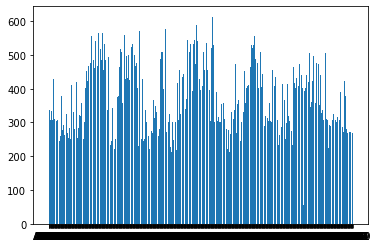

In [177]:
plt.bar(df2020_2021_r1.Code, df2020_2021_r1.R1_POINTS)


In [178]:
plt.show()

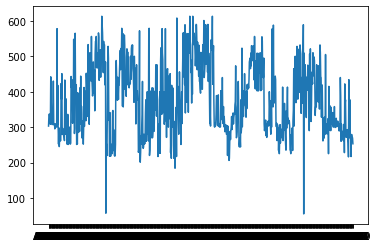

In [179]:
plt.plot(df2020_2021_r1.Code, df2020_2021_r1.R1_POINTS)

In [181]:
df2020_2021_r1.nlargest(10, 'R1_POINTS')

,Code,Title,points_R1_2021,COURSE_TITLE,R1_POINTS
144,CK702,Dentistry,625.0,Dentistry,613.0
382,TR034,Management Science and Information Systems Stu...,625.0,Management Science and Information Systems Stu...,613.0
390,TR052,Dental Science,625.0,Dental Science,613.0
443,DN670,Economics and Finance,625.0,Economics and Finance,613.0
347,TU961,Commercial Modern Music (BIMM - assessment/aud...,536.0,Commercial Modern Music,608.0
420,DN230,Actuarial and Financial Studies,613.0,Actuarial and Financial Studies,601.0
145,CK703,Pharmacy,613.0,Pharmacy,590.0
399,TR072,Pharmacy,613.0,Pharmacy,590.0
431,DN440,Biomedical Health and Life Sciences,613.0,"Biomedical, Health and Life Sciences",590.0
369,TR015,Philosophy Political Science Economics and S...,613.0,"Philosophy, Political Science, Economics and S...",589.0


In [182]:
df2020_2021_r1_nlargest = df2020_2021_r1.nlargest(10, 'R1_POINTS')

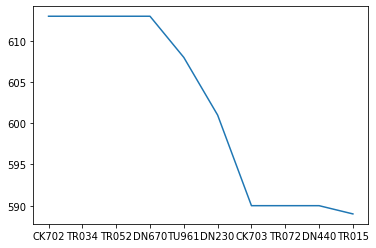

In [183]:
plt.plot(df2020_2021_r1_nlargest.Code, df2020_2021_r1_nlargest.R1_POINTS)

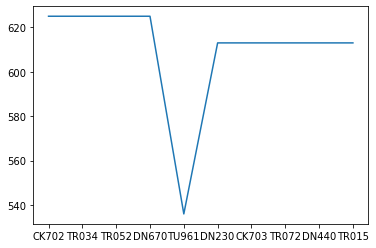

In [184]:
plt.plot(df2020_2021_r1_nlargest.Code, df2020_2021_r1_nlargest.points_R1_2021)

TypeError: unhashable type: 'numpy.ndarray'

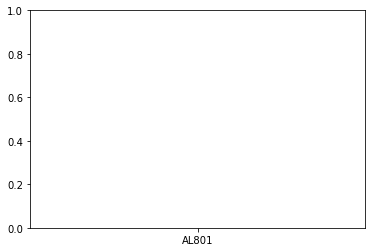

In [180]:
plt.plot(df2020_2021_r1.Code, df2020_2021_r1.nlargest(10, 'R1_POINTS'))

Comparing the unique titles from 2021 and 2020. On analysis it was found there more unique courses in 2020 than in 2021. Courses removed/merged together

Adding 2021 and 2020 R1 points to one data set

### Basic Maths on the 2021/2020 Data

In [ ]:
# Trying to find max and min scores for R1 in 2020 and 2021
# df2021.points_R1_2021.max()

In [ ]:
# df2021.loc[df2021["points_R1_2021"]==1028]

In [ ]:
# df2021.points_R1_2021.min()

It was found that CR125 had 1028 points for entry into this course as it took into account the portfolio on the Leaving Certificate points. In order not to skew the data this course will be removed from the analysis as we cannot say how many points were required from the Leaving Certificate and how many required from the portfolio. Further courses were found to be above 625 and were therefore also removed from the analysis as they are a mix of 

In [ ]:
# df2021 = df2021.loc[df2021['points_R1_2021'] != 1028.0]

In [ ]:
# len(df2021)

In [ ]:
# df2021.points_R1_2021.max()

In [143]:
# df2021.loc[df2021["points_R1_2021"]==993.0]

In [144]:
# df2021.loc[df2021["points_R1_2021"]>625.0]

In [145]:
# df2021 = df2021.loc[df2021["points_R1_2021"]<=625.0]

In [146]:
# df2021.points_R1_2021.max()

In [147]:
# df2021.points_R1_2021.min()

In [148]:
# df2021

In [149]:
# df2020

In [150]:
# df2020.R1_POINTS.max()

In [151]:
# df2020.points_R1_2020.min()

In [152]:
# df2020.info()

## Comparing the 2019 , 2018 and 2017 Data

### 2019 Courses

In [ ]:
df2019.Title.unique()

In [ ]:
len(df2019.Title.unique())

In [ ]:
df2019['Mid_2019'].to_frame()

### 2018 Courses

In [ ]:
df2018.Title.unique()

In [ ]:
len(df2018.Title.unique())

In [ ]:
df2018['Mid_2018'].to_frame()

### 2017 Courses

In [ ]:
df2017.Title.unique()

In [ ]:
len(df2017.Title.unique())

In [ ]:
df2017['Mid_2017'].to_frame()

In [ ]:
df2019.Title.unique() == df2018['Title'].unique()

In [ ]:
df2019.Title.unique() == df2017['Title'].unique()

In [ ]:
df2018.Title.unique() == df2017['Title'].unique()

In [ ]:
df2019.points_Mid_2019.max()

In [ ]:
df2019.points_Mid_2019.min()

# References
<sup>1</sup>[Central Applications Office](https://en.wikipedia.org/wiki/Central_Applications_Office)  
<sup>2</sup>[Irish Leaving Certificate Examination Points](https://www.cao.ie/index.php?page=scoring&s=lcepointsgrid)  
<sup>3</sup>[Requests:HTTP for Humans](https://docs.python-requests.org/en/latest/)  
<sup>4</sup>[Requests:Quickstart](https://docs.python-requests.org/en/latest/user/quickstart/)  
<sup>5</sup>[200 OK](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/200)  